# CS 2316 Final Project - Analysis

## Data Sources

*   Downloaded Dataset (Covid data): https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD
*   Web Collection #1 Source (stock market data): https://finance.yahoo.com/quote/%5EGSPC/history/
*   Web Collection #2 Source (article data): https://open-platform.theguardian.com/access/



In [2]:
def period_adv(newcovvl,doww):  #function for averaging values between stock market trading days
    mask = newcovvl["submission_date"].isin(doww["Date"].values) #find the covid data dates on stock trading days
    s = 0        #initializing for loop
    divisor = 1
    
    for each in range(1,len(newcovvl)):           
        if mask[each] == False:     #finds if a covid entry date is not in the dow data
            value += newcovvl.iloc[each,11]     #add cases to value to be reassigned later
            divisor += 1    #create a divisor based on number of values added to get an average
            s = 1    #establish this row is not a trading day
        else:
            if s == 1:  #previous date not a trading day
                newcovvl.iloc[ind,11] = (value/divisor)   #store average value of cases at the last trading date
                s = 0      #establish this row is a trading day
                divisor = 1 #reset divisor
            else:
                value = newcovvl.iloc[each,11]    #establish value to be used in adverage if the next day is a non trading date
                ind = each                   #store the indicy of this row to later change data
                s = 0         #establish this row is a trading day
    return newcovvl

I added this function as I found myself using this code in a few different insights. This function takes in my covid data and my dow jones data as inputs and outputs an averaged version of the covid data. The total cases covid data is averaged for dates in between stock trading days. This is done in order to compare the average daily number of covid cases in between opens of the stock market rather than just compare the covid cases and dow open on the same dates. This loop makes the correlation comparison more accurate as it allows all of the covid data to be taken into consideration.

# Data Visualizations
In order to make my insights more understandable and to aid in analysis, I included visualizations under my insights. The code for visualizations at the bottom of the insights and is clearly spereated. There are also seperate explainations for the visualizations.

## Insights

# Insight 1: Correlation between Dow Jones price and daily covid-19 cases

Spearman correlation test results
Correlation Coefficient: 0.032246195161765225


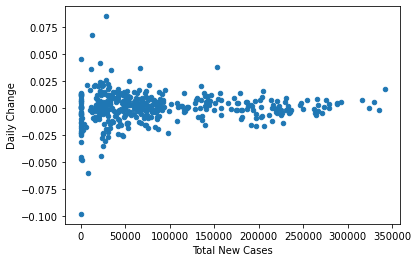

In [78]:
def insight1():
    import pandas as pd
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings('ignore')  # was giving a chained assignment warning but it isn't an issue in this context
    
    with open("COV_dat.csv") as fc:                #importing csv data to a pandas df
        newcovv = pd.read_csv(fc,delimiter = ",")
    with open("DOW_price.csv") as fd:
        doww = pd.read_csv(fd,delimiter = ",")
        
    
    #sum probable and confirmed new cases to get total new cases
    newcovv["totnew_case"] = newcovv["new_case"]+newcovv["pnew_case"]
    
    newcovv["totnew_case"] = newcovv["totnew_case"].astype(int)

    newcovvl = newcovv.iloc[1:,:]       #first covid date not in dow data; clipping this allows the function to run properly
    peradv = period_adv(newcovvl,doww)
    newcovv.iloc[1:,:] = peradv
    
    newcov2 = newcovv[newcovv["submission_date"].isin(doww["Date"].values)]  #remove rows with dates not in dow dataframe
    newcov2.reset_index(drop =True,inplace = True)
    
    doww["Daily Change"] = doww["Open"].pct_change() #converting dow opens into daily % changes
    doww = doww.iloc[1:,:]   # clipping first value as pct chagne retruns a Nan for the first value
    newcov2 = newcov2.iloc[:-1,:]  #clipping last value to match length of doww and compare covid cases from one day
    #with the change of the open the next trading day
    doww.reset_index(drop =True,inplace = True) #reset the indexes so doww and covv indexes aligned when concatenating

    reg = newcov2["totnew_case"].corr(doww["Daily Change"],method="spearman")
    print(f"Spearman correlation test results\nCorrelation Coefficient: {reg}")
    
    newcov2["Total New Cases"] = newcov2["totnew_case"]
    plot_df = pd.concat([newcov2, doww], axis =1)         #getting data for scatter plot in one df
    plot_df = plot_df[["Total New Cases", "Daily Change"]]
    
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ### VISUALIZATION for INSIGHT 1
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_df.plot.scatter(x='Total New Cases', y='Daily Change')

############ Function Call ############
insight1()

## Insight 1 Explanation
* **Insight**:</br>
I wanted to compare the daily number of new covid cases with the change between the dow jones industrial adverage open of that day and the next trading day. I chose to use this percent change for the dow as it allows time for the covid data to have been released and the stock market to react to this data. In alginment with looking at the reation to the number of covid cases, I averaged the daily number of new covid cases over periods where the stock market wasn't trading in order to match all the covid data available between two dow opens with the change of those opens. I used a spearman correlation test which doesn't assume the two datasets have a linear relationship (as compared to a pearson correlation test) which returned that there is a small positive correlation between the two of .032246. This result suggests that there is little correlation between the two as the correlation coefficient is so small however the correlation skews slightly positive which comes accross as counterintuitive.
* **Visualization**:</br>
This plotting function returns a scatter plot where I designate the x-axis to be the total amount of new cases per day(or the averaged number of cases over a period of days) and y the change in the opening price of the dow jones industrial average(in terms of percentage). I did this in order to show the overall distribution of how these two data sets correlate. We can see that there is a greater spread of dow open changes when the number of new covid cases is lower, as well as a few outlier changes. At higher values for the number of new covid cases, the change in the dow price stays closer to 0. Speculating, this trend could be due to the market being more volatile during the beginning of the pandemic, when there were less new covid cases daily, and the market becoming less volatile once the pandemic progessed and the economic/health effects were beter understood.

# Insight 2: The death rate of Covid-19 over time

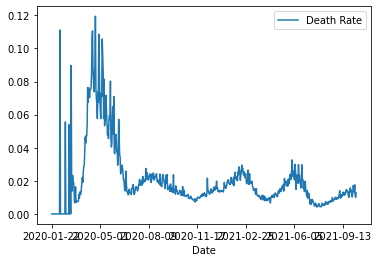

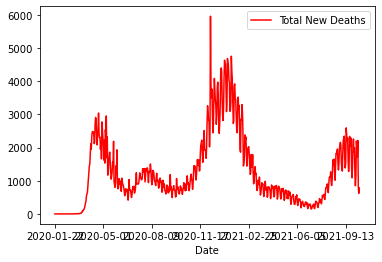

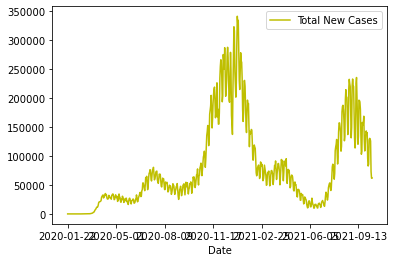

In [6]:
def insight2():
    import pandas as pd
    with open("COV_dat.csv") as f:
        cdata = pd.read_csv(f, delimiter = ",")
        
        cdata["Total New Cases"] = cdata["new_case"]+cdata["pnew_case"]     #sum probable with confirmed deaths/cases
        cdata["Total New Deaths"] = cdata["new_death"]+cdata["pnew_death"]
        
        cov = cdata[["submission_date", "Total New Cases", "Total New Deaths"]] #compile needed data
        cov = cov.sort_values(by = "submission_date", ascending = True)  #sort by date
        cov["Death Rate"] = cov["Total New Deaths"]/cov["Total New Cases"]  #compute death rate; new deaths/new cases
        cov["Death Rate"]= cov["Death Rate"].fillna(0)
        cov["Date"] = cov["submission_date"]
        
        
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ### VISUALIZATION for INSIGHT 2
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    cov.plot.line(x="Date", y="Death Rate")
    cov.plot.line(x="Date", y="Total New Deaths",color="r")
    cov.plot.line(x="Date", y="Total New Cases",color="y")


############ Function Call ############
insight2()

### Insight 2 Explanation
* **Insight**:</br>
Here I looked at the death rate over time of covid-19. We can see that at the very beginning of the pandemic there are some large, short lived spikes likely due to a lack of data and consistent testing. However shortly after this there is a more sustained spike with a significantly higher death rate compared to later dates. We can also see that this coincides with a relatively low amount of total cases which is interesting. After this, later spikes in the death rate are smaller and coincide with spikes in cases.
* **Visualization**:</br>
I plotted 3 line graphs first showing the death rate and then showing the actual new cases and new deaths in order to show the data behind the death rate and allow a better understanding of the data. I used 3 different graphs due to the difference in the scale of the dependant variables. This would make the graph hard to read if they were all plotted on the same graph, however we can still analyze the trends based on the spikes in the different graphs.

# Insight 3: What time shift gives the greatest correlation between covid cases and the stock market?

In [4]:
def insight3():
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')
    with open("DOW_price.csv") as fdd:              
        prices = pd.read_csv(fdd, delimiter = ",")
    with open("COV_dat.csv") as fcd:
        vid = pd.read_csv(fcd,delimiter = ",")
        
    vid["totnew_case"] = vid["new_case"]+vid["pnew_case"]
    
    vid["totnew_case"] = vid["totnew_case"].astype(int) 
    vidl = vid.iloc[1:,:]         #first covid date not in dow data; clipping this allows this loop to run properly

    vidl = period_adv(vidl,prices)
    vid.iloc[1:,:]=vidl
    newv = vid[vid["submission_date"].isin(prices["Date"].values)]#remove rows with dates not in dow dataframe 
    newv.reset_index(drop =True,inplace = True)
    
    prices["Open"] = prices["Open"].astype(int)
    prices["Daily Change"] = prices["Open"].pct_change()
    prices = prices.iloc[1:,:]  # clipping first row as pct chagne retruns a Nan for the first value
    prices.reset_index(drop =True,inplace = True)  #makes row indexes start at 0 instead of 1
    newv = newv.iloc[:-1,:]   #removing the last row to match the length of the dow data
    
    marketdates = list(prices["Date"]) #storing dates for useage in loop
    out = [] #initializing list to store values from loop
    for i in range(22): #chose to look at up to approx. a month later (uses trading days only)
        cor = newv["totnew_case"].corr(prices["Daily Change"],method="spearman") #find correlation between cases and price change
        out += [(i,cor)]   #adds day offset and correlation touple to out list
        
        marketdates = marketdates[1:]  # shift the dates so market data corresponds with covid data from an earlier date
        prices = prices.iloc[:-1,:]
        prices["Date"] = marketdates
        
    t = max(out,key=lambda item:item[1]) #finds the offset with the highest correlation and returns that touple
    df = pd.DataFrame(out, columns=['days_after', 'correlation']) #make out list into a pd dataframe
    df = df.sort_values(by = "correlation", ascending = False)
    display(df)
    print("Time shift with the greatest correlation (days,correlation coefficient)")
    print(t)

############ Function Call ############
insight3()

,days_after,correlation
21,21,0.041990
20,20,0.040317
18,18,0.038591
16,16,0.037081
19,19,0.037079
15,15,0.035525
17,17,0.035225
10,10,0.033956
9,9,0.032986
8,8,0.032631


Time shift with the greatest correlation (days,correlation coefficient)
(21, 0.04198950837120494)


### Insight 3 Explanation

* **Insight**:</br>
Here I decided to investigate the correlation between new covid cases and percent change in open of the dow jones as in insight 1 but with different time shift amounts to see if there is a greater correlation between the two datasets when comparing dow open changes with covid case changes from days before. I looked at up to 21 trading days(around a month) between the covid case data(earlier) and the dow jones data(later). The outputed table is put in descending order and we can see that the highest correlation is seen when looking at a 20-21 trading day delay. Also the values with the highest correlations tended to have a large time offset (>10).

# Insight 4: correlation between covid-19 cases and economic sectors

Open                      0.032246
Energy                    0.094109
Financial Services        0.085084
Technology               -0.043831
Real Estate              -0.003554
Communication Services   -0.017975
Utilities                -0.016763
Consumer Staples         -0.016936
Healthcare                0.025942
Basic Materials           0.042399
New Cases                 1.000000
Name: New Cases, dtype: float64


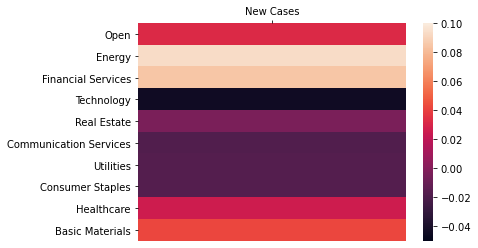

In [76]:
def insight4():
    import pandas as pd
    import seaborn as sns
    with open("Sector_Prices2.csv") as fsec:
        sec = pd.read_csv(fsec,delimiter = ",")
    with open("COV_dat.csv") as fcd:
        vid = pd.read_csv(fcd,delimiter = ",")
        
    vid["totnew_case"] = vid["new_case"]+vid["pnew_case"]
    

    vid["totnew_case"] = vid["totnew_case"].astype(int) 
    vidl = vid.iloc[1:,:]         #first covid date not in dow data; clipping this allows this loop to run properly

    vidl = period_adv(vidl,sec)
    vid.iloc[1:,:]=vidl
    newv = vid[vid["submission_date"].isin(sec["Date"].values)]  #remove rows with dates not in dow dataframe
    newv.reset_index(drop =True,inplace = True)
    
    #get the daily change in the open for each sector
    for z in sec.columns:
        if z not in ["New Cases","Date","Open"]: #exclude columns where pct chagne not applicable
            sec[f"{z}"] = sec[f"{z}"].pct_change()
    sec["Open"] = sec["Open"].pct_change()
    
    newv = newv.iloc[:-1,:] #realign values as pct change returns nan for the first value
    sec = sec.iloc[1:,:]
    sec.reset_index(inplace = True)
    
    sec["New Cases"] = newv["totnew_case"]
    sec = sec.fillna(0)
    
    print(sec.corr(method = "spearman").iloc[1:,11])
    
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ### VISUALIZATION for INSIGHT 4
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax = sns.heatmap(sec.corr(method = "spearman").transpose().iloc[1:-1,[11]], vmin=-.05,vmax=.1)
    ax.xaxis.set_ticks_position('top')
    

############ Function Call ############
insight4()

### Insight 4 Explanation
* **Insight**:</br>
For this insight I used web scraped data of historical price data from indexes of the largest sectors in the stock market and economy. I chose to look at this in order to see if certain sectors of the economy were more corelated to new covid cases than the market as a whole. We can see on the correlation plot that the dow jones(open) has a lower correlation with new covid cases than basic materials, financial services, and energy with energy and financial services being much more correlated with new covid cases than basic materials and covid cases. Also, trechnology has a fairly significant negative correlation with new covid cases.

# Insight 5: Correlation between Dow Jones and covid-19 related articles

Correlation coefficient:
-0.21875318745676767


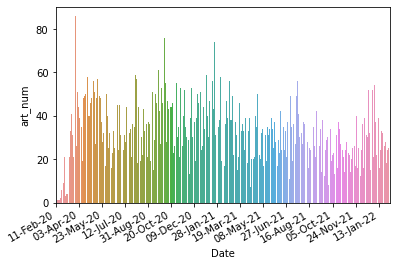

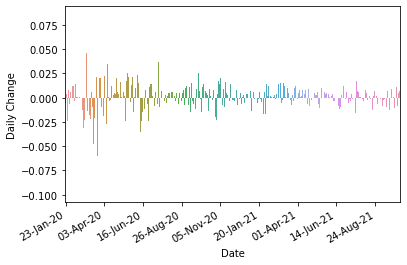

In [5]:
def insight5():
    import pandas as pd
    from datetime import datetime
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib import dates
    import copy
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    with open("DOW_price.csv") as fc:
        prices = pd.read_csv(fc, delimiter = ",")
        #print(prices)
    with open("api_dic_session3.csv") as f:
        news = pd.read_csv(f, delimiter = ",", names = ["Date","art_num"])
    new = copy.deepcopy(news) 
    mask = news["Date"].isin(prices["Date"].values) #find the covid dates that are in the dow dates
    s = 0        #initializing for loop
    divisor = 1
    value = 1
    ind = -1
    #comments for loop under insight 1
    for each in range(1,len(news)):          
        if mask[each] == False:
            value += news.iloc[each,1]
            divisor += 1
            s = 1
        else:
            if s == 1:
                if ind != -1:
                    news.iloc[ind,1] = (value/divisor)
                    s = 0
                else:
                    s = 0
                divisor = 1
            else:
                value = news.iloc[each,1]
                ind = each
                s = 0
                
    mult = prices.merge(news, on = "Date", how = "left")
    mult = mult.fillna(0)
    corr = mult["Open"].corr(mult["art_num"],method="spearman")
    print("Correlation coefficient:")
    print(corr)
    
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ### VISUALIZATION for INSIGHT 5
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~

    prices["Open"] = prices["Open"].astype(int)
    prices["Daily Change"] = prices["Open"].pct_change()
    prices = prices.iloc[1:,:]  # clipping first row as pct chagne retruns a Nan for the first value
    prices = prices.reset_index(drop = True)  #makes row indexes start at 0 instead of 1
    
    new['Date'] = pd.to_datetime(new['Date'], format='%Y/%m/%d') #sort article number by date
    new = new.sort_values("Date")
    new.reset_index(drop = True, inplace=True)

    fig, ax = plt.subplots()
## barplot
    chart = sns.barplot(data=new, ax=ax,x="Date",y="art_num")


    ax.set_xticklabels(new["Date"].dt.strftime("%d-%b-%y"))  # set the xlabels as the data in datetime form

    xtix = ax.get_xticks()    # set the xticks at an interval of 50 so dates are legible
    ax.set_xticks(xtix[::50])

    fig.autofmt_xdate()   # better label format for dates
    plt.show()
    
    #second graph follows the same process as the first
    prices['Date'] = pd.to_datetime(prices['Date'], format='%Y/%m/%d')
    fig2, ax2 = plt.subplots()
    chart2 = sns.barplot(data=prices, ax=ax2,x="Date",y="Daily Change")

    ax2.set_xticklabels(prices["Date"].dt.strftime("%d-%b-%y"))

    xtix = ax2.get_xticks()
    ax2.set_xticks(xtix[::50])

    fig2.autofmt_xdate()
    plt.show()


############ Function Call ############
insight5()

### Insight 5 Explanation

* **Insight**:</br>
In this insight I found the correlation between the change in dow jones opens and the number of articles mentioning covid or coronavirus from the guardian's api. I used the same averaging method as the period_adv() function but with slight modifications to fit the article data. I used a spearman correlation test here aswell. The correlation coefficient is -.21875... which is a significant negative correlation.
* **Visualization**:</br>
I plotted bar graphs of both the number of articles and the daily change of the dow jones. There apear to be spikes in articles about covid and negative dow days which is reflected in the correlation coefficient.

## Summary
In this analysis we are comparing three data sets. The first is the daily open price of the dow jones inustrial average, the second is the number of articles mentioning covid or coronavirus daily as detemined through the guardian api, and the third is the number of confirmed and probable covid cases and deaths daily from the cdc. This analysis looks at the time from the beginning of 2020 to the beginning of 2022, encompassing the beginning of the covid-19 pandemic almost up to the present day. For this analysis I created some new values from the collected data. For the dow jones I got the percentage change from one open to the next. I opted to use this for correlation comparisons with the other two datasets as it encompasses a timeframe where the stock market has time to react to the covid data coming out, as well as news stories coming out. For the covid data I summed probable and confirmed cases and deaths to get a total number for each. Also, when comparing the number of articles or covid cases to the dow daily change, I run the datasets through the period_adv() function. This function takes in the original dataset and the dow jones dataset and averages the data of the original dataset over periods where the stock market isn't trading. This is done in order to compare all the data coming out between two dow opens with the percentage change of the dow after that period. I use correlations often for this project and I use the spearman correlation test as it doesn't assume that the two variables are linearly related as a pearson correlation test does, but rather it determines the strength and direction of the monotonic relationship between your two variables. A monotonic relationship is one where one variable increases as the other increases(positive correlation value), or one varible increases as the other decreases(negative correlation value).        For <b>insight 1</b> I found the spearman correlation between the change in dow opening prices and the number of covid cases. The correlation is .0322... which means there is a very small positive relationship between these two variables. The scatter plot shows that the range of percentage change of the dow is much larger with lower numbers of covid cases but the changes stay closer to 0 at higher numbers of covid cases. For <b>insight 2</b> I looked at the death rate of covid over time compared to the total cases and total deaths by looking at line graphs of all three. The death rate for covid had a few short lived initial spikes which are likely due to lack of data and consistent testing at the beginning of the pandemic, however after this there is a sustained spike in the death rate for around 3 months centered on May 2020 peaking at a death rate of .08. After this spike the death rate stays close to .02 with slight spikes around half a month after spikes in cases. For <b>insight 3</b> I did the same correlation test as in insight 1 but I offset the Dow data by 1 up to 21 trading days. I did this in order to see if there would be a delayed reaction to covid cases from the Dow. The results were that the highest correlation was found at an offset of 21 trading days(around an actual month) with a correlation of .04199 as compared to the non offset correlation of .032253. It was also an interesting result that the 8 highest correlations were for offsets of greater than 10 trading days. For <b>insight 4</b> I compared daily covid cases to the daily change in open of sector index funds for the top ecomonic sectors. I did this in order to see the impact of covid on specific sectors. All correlations are shown under insight 4 with an interesting result being energy and financial services having over double the positive correlation value that the Dow Jones did. Lastly for <b>insight 5</b> I found the correlation between the number of articles mentioning covid or coronavirus and the change in the Dow Jones open. The correlation coefficient between these two datasets is -.21875.

## Conclusion

Looking at the different insights together, there are certain interesting results. Looking at the correlation between the Dow and covid cases vs the correlation between the Dow and the number of covid related articles, it is counterintuitive that the Dow and covid correlation is slightly positive at .0322 while the Dow and article correlation is negative at -.21875. Even when looking at the different date offsets and different economic sectors, the Dow and covid correlation is never close to as negative as the Dow and article correlation. These results suggest that the change in the dow had more to do with the media coverage of covid-19 than the reality of the spread of the virus. This supports the idea that the current stock market operates primarily on speculation and expectation rather than the current reality. The scatter plot under insight 1 also supports this idea as at lower numbers of new covid cases the magnitude of the daily dow open changes is much larger than for higher number of covid cases. These lower number of cases occured near the beginning of the pandemic when speculation on the effects of covid was large. Now looking at insight 3, there appears to be a delayed reaction of the Dow jones to new covid cases due to the correlation coefficient being larger for greater time offsets. This could be the result of slow releasing of official covid numbers and/or a delay in companies feeling the economic losses of people getting covid. From insight 2, the death rate had one large spike near the beginning of the pandemic, this is likely due to insufficient testing, vulnerable individuals being killed, and lack of healthcare resources. Ultimately, the main question this analysis stands to answer is did the number of covid cases or the number of articles about covid have a greater negative influence on the stock market's performance? From this investigation it appears that the number of articles had a greater negative influence on the stock market's performance. However, these are just correlations and no definitive conclutions can be gathered. There are also questions surrounding the covid dataset's validity. The number of confirmed cases comes only from individuals who were tested for covid and I am unsure of the method of determining probable new cases and deaths so I do not know it's validity yet it is from some model or simulation so it can't be perfectly reflecting reality. On the other hand, the other two datasets have valid data for what they are trying to measure, but the dow jones is simply an index of the market and only reflects the performance of the largest publically traded companies, not the entire stock market, and the guardian api doesn't have all articles that were released so I don't know if it is a representative sample of articles released during this time period.

## Summary File

In [75]:
def summary1():
    import pandas as pd
    with open("DOW_price.csv") as fc:
        pricesDF = pd.read_csv(fc, delimiter = ",")
    with open("api_dic.csv") as f:
        newsDF = pd.read_csv(f, delimiter = ",", names = ["Date","art_num"])
    with open("COV_dat.csv") as f:
        cov_data = pd.read_csv(f, delimiter = ",")
        cov_data["tot_new_cases"] = cov_data["new_case"]+cov_data["pnew_case"]
        cov_data["tot_new_deaths"] = cov_data["new_death"]+cov_data["pnew_death"]
        covDF = cov_data.sort_values(by = "submission_date", ascending = True)
        covDF["death_rate"] = covDF["tot_new_deaths"]/covDF["tot_new_cases"]
    covDF = covDF.rename(columns={"submission_date": "Date"})
    presummaryDF = covDF[covDF.Date.isin(newsDF.Date.values)]
    presummaryDF = presummaryDF.merge(newsDF, on = "Date", how = "left")
    summaryDF = presummaryDF.merge(pricesDF, on = "Date", how = "left")
    summaryDF = summaryDF.fillna(0)
    print(summaryDF.head())
    writer = pd.ExcelWriter("Cleaned_Covid_Summary.xlsx")
    summaryDF.to_excel(writer)
    writer.save()




############ Function Call ############
summary1()

         Date  tot_cases  conf_cases  prob_cases  new_case  pnew_case  \
0  2020-02-11        599       584.0         9.0         9        3.0   
1  2020-02-14        619       602.0        11.0         6        1.0   
2  2020-02-16        637       616.0        15.0        13        3.0   
3  2020-02-18        662       639.0        15.0         7        0.0   
4  2020-02-20        693       665.0        18.0        14        2.0   

   tot_death  conf_death  prob_death  new_death  pnew_death  tot_new_cases  \
0        250       250.0         0.0          0         0.0           12.0   
1        250       250.0         0.0          0         0.0            7.0   
2        250       250.0         0.0          0         0.0           16.0   
3        250       250.0         0.0          0         0.0            7.0   
4        251       251.0         0.0          0         0.0           16.0   

   tot_new_deaths  death_rate  art_num          Open  
0             0.0         0.0        